**OBJECTIVE:** create a competitive template for classification models that handle categorical data such as the 'amazon.com' dataset. This notebook serves as a guide for data scientists intent on starting some competition.

**IMPORTANT:** This notebook is not aimed at achieving the absolute highest score for the "amazon.com" dataset, but my purpose is to provide some of the data coding and multi-model inference strategies

If you can do better, copy and edit this notebook

***Please, UPVOTE for this notebook to motivate me to create more projects that are a source of learning for data scientists.***

**I hope to receive a gold medal for this long project :)**

# Step 1: Data reading and insight

**Data Description**

The data consists of real historical data collected from 2010 & 2011.  Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees. 

**File Descriptions**

train.csv - The training set. Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval

test.csv - The test set for which predictions should be made.  Each row asks whether an employee having the listed characteristics should have access to the listed resource.

**Column Descriptions**

Column Name: Description

ACTION: ACTION is 1 if the resource was approved, 0 if the resource was not

RESOURCE: An ID for each resource

MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time

ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering)

ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail)

ROLE_DEPTNAME: Company role department description (e.g. Retail)

ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager)

ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering)

ROLE_FAMILY: Company role family description (e.g. Retail Manager)

ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-deep')

import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import random


seed = 12
np.random.seed(seed)

from datetime import date

In [ ]:
# read the data using pandas dataframe
amazon = pd.read_csv('../input/amazon-employee-access-challenge/train.csv')
amazon_test = pd.read_csv('../input/amazon-employee-access-challenge/test.csv')

amazon.head(5)

In [ ]:
# important funtions (optionals)
def datasetShape(df):
    rows, cols = df.shape
    print("The dataframe has",rows,"rows and",cols,"columns.")
    
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number]).drop('ACTION', axis=1)
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [ ]:
amazon.info()

# Step 2: EDA

In [ ]:
print("Unique values")
(pd.concat([amazon.drop('ACTION', axis = 1).apply(lambda x: len(x.unique())), 
            amazon_test.drop('id', axis = 1).apply(lambda x: len(x.unique()))
           ], axis="columns")
 .rename(columns={0: "train", 1:"test"}))

In columns MGR_ID, ROLE_DEPTNAME, ROLE_TITLE, ROLE_FAMILY_DESC, and ROLE_CODE, there are more unique values in the test set than in the training set

In [ ]:
# check null values

print("Missing cases")
(pd.concat([amazon.drop('ACTION', axis = 1).isna().sum(), 
           amazon_test.drop('id', axis = 1).isna().sum()
           ], axis="columns")
 .rename(columns={0: "train", 1:"test"}))

There are no missing values

In [ ]:
print("Values in test but not in train")
integer_cols = amazon.drop('ACTION', axis = 1).select_dtypes(include=['int']).columns
for col in integer_cols:
    mismatched_codes = len(np.setdiff1d(amazon[col].unique(), amazon_test[col].unique()))
    print(f"{col:20} {mismatched_codes:4}")

There are many RESOURCE values not present in the train set but present in the test set

In [ ]:
sns.color_palette("Blues", as_cmap=True)
GnBu_palette = sns.color_palette("GnBu",10)
Blues_palette = sns.color_palette("Blues",10)
sns.palplot(Blues_palette)
sns.palplot(GnBu_palette)

# Distribution Analysis

Checking the distribution of the data (first with the probability distribution and later with histograms)

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(3,3, figsize=(14,10), sharex=True)
sns.despine(left=True)

# Probability distribution
ax = sns.distplot(amazon['RESOURCE'], hist=False, ax=axes[0, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['MGR_ID'], hist=False, ax=axes[0, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_ROLLUP_1'], hist=False, ax=axes[0, 2])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_ROLLUP_2'], hist=False, ax=axes[1, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_DEPTNAME'], hist=False, ax=axes[1, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_TITLE'], hist=False, ax=axes[1, 2])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_FAMILY_DESC'], hist=False, ax=axes[2, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_FAMILY'], hist=False, ax=axes[2, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(amazon['ROLE_CODE'], hist=False, ax=axes[2, 2])
ax.set(ylabel='Probability')

In [ ]:
# Distribution with histograms

_ = amazon.astype(int).hist(bins=99, figsize=(14, 14), layout=(5, 2))

# Correlation check

In [ ]:
#Lets plot correlation matrix
plt.figure(figsize=(15,8))
corr = amazon.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap= GnBu_palette)

There are no strong correlations, but moderate correlations between:

MGR_ID vs ROLE_FAMILY

ROLE_TITLE vs ROLE_CODE

ROLE_TITLE vs ROLE_FAMILY_DESC 

ROLE_FAMILY_DESC vs ROLE_FAMILY

ROLE_FAMILY vs ROLE_CODE

In [ ]:
#Scatter Plot between MGR_ID and ROLE_FAMILY
sns.scatterplot('MGR_ID', 'ROLE_FAMILY', data=amazon, hue = 'ACTION')

No correlations

In [ ]:
#Scatter Plot between ROLE_TITLE and ROLE_CODE
sns.scatterplot('ROLE_TITLE', 'ROLE_CODE', data=amazon, hue = 'ACTION')

Good correlation between the two variables. We can consider selecting only one for the model training step

In [ ]:
#Scatter Plot between ROLE_TITLE and ROLE_FAMILY_DESC
sns.scatterplot('ROLE_TITLE', 'ROLE_FAMILY_DESC', data=amazon, hue = 'ACTION')

No correlations

In [ ]:
#Scatter Plot between ROLE_FAMILY and ROLE_FAMILY_DESC
sns.scatterplot('ROLE_FAMILY', 'ROLE_FAMILY_DESC', data=amazon, hue = 'ACTION')

No correlations

In [ ]:
#Scatter Plot between ROLE_FAMILY and ROLE_CODE
sns.scatterplot('ROLE_FAMILY', 'ROLE_CODE', data=amazon, hue = 'ACTION')

No correlations

# Target variable check

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

amazon['ACTION'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[5]]
)

sns.countplot('ACTION',data=amazon,ax=axes[1], palette=[Blues_palette[1],Blues_palette[5]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of Outcome percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

- Highly unbalanced class (consider data balancing, or algorithms handling this issue )

# Step 3: Feature Engineering

In [ ]:
y = amazon['ACTION']
train = amazon.drop('ACTION', axis = 1)

#Dropping ROLE_TITLE feature because is correlated with ROLE_CODE
train = train.drop('ROLE_TITLE', axis = 1)

test = amazon_test.drop('ROLE_TITLE', axis = 1)
test = test.drop('id', axis = 1)

The variables in our dataset are all categorical, so we will try different encoding methods to handle them

**What is Categorical Encoding?** (See https://towardsdatascience.com/6-ways-to-encode-features-for-machine-learning-algorithms-21593f6238b0 for details)

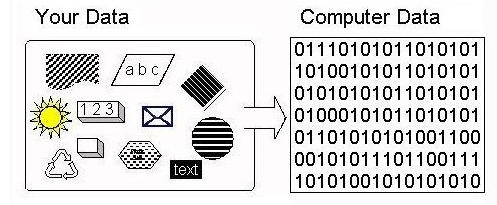

**1. Label Encoding** (based on alphabetical sorting, each label is assigned a unique integer in this approach)

In [ ]:
from sklearn import preprocessing

def lab_enc(df_train, df_cv, column):
    le = preprocessing.LabelEncoder()
    le.fit(df_train[column])
    df_train_le = le.transform(df_train[column])
    df_cv[column] = df_cv[column].map(lambda s: 0 if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, 0)
    df_cv_le = le.transform(df_cv[column])
    return df_train_le, df_cv_le

**2. Binary Encoding** (binary encoding is a technique that converts categorical data to numerical data by encoding categories as integers and then converting them to binary code)

In [ ]:
from category_encoders import BinaryEncoder

def bin_enc(X_train, Y_train, X_cv):
    binary_enc = BinaryEncoder(cols=X_train.columns).fit(X_train, Y_train)
    X_train_binary = binary_enc.transform(X_train.reset_index(drop=True))
    X_val_binary = binary_enc.transform(X_cv.reset_index(drop=True))
    return X_train_binary, X_val_binary

**3. One-Hot Encoding** (categorical data are represented as vectors of zeros and ones in one-hot encoding. This is accomplished by creating a distinct dummy variable for each category and changing its value to 1 if the observation corresponds to that category and 0 otherwise)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def onehot_enc(df_train, df_cv):
    one_hot_enc = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
    data_ohe_train = (one_hot_enc.fit_transform(df_train))
    data_ohe_val = (one_hot_enc.transform(df_cv))
    return data_ohe_train, data_ohe_val

**4. Frequency Encoding** (count encoding is a means of describing categorical data by counting the number of categories)

In [ ]:
#Source: https://www.kaggle.com/bhavikapanara/frequency-encoding
def freq_enc(df_train, df_cv, column):
    train = (df_train.groupby(column).size()) / len(df_train)
    cv = (df_cv.groupby(column).size()) / len(df_cv)
    freq_enc_train = df_train[column].apply(lambda x : train[x])
    freq_enc_cv = df_cv[column].apply(lambda x : cv[x])
    return freq_enc_train, freq_enc_cv

**5. Feature Hashing** (a fixed-size array is used in feature hashing to represent data in a high-dimensional space. This is accomplished by using a hash function to encode category information)

In [ ]:
def hash_enc(df_train, df_cv, n_components):
    hashing_enc = HashingEncoder(cols=df_train.columns, n_components=n_components).fit(X_train, y)
        
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_val_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    return X_train_hashing, X_val_hashing

# Generate new dataset

**Why do we need to generate new datasets?**

Because the test set may contain information not present in the training set, so we need to generate as much variability as possible. This process is similar to data augmentation for image data

In [ ]:
# Converting all int variables to object for the new data generation
integer_cols = train.select_dtypes(include=['int']).columns
train[integer_cols] = train[integer_cols].astype('str', copy=False)
test[integer_cols] = test[integer_cols].astype('str', copy=False)

In [ ]:
from itertools import combinations

target_cols = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

new_col_train = target_cols

# Combination of two variables
for c1, c2 in combinations(target_cols, 2):
    name = "{}_{}".format(c1,c2)
    new_col_train.append(name)
    train[name] = train[c1] + train[c2]
    test[name] = test[c1] + test[c2]

In [ ]:
target_cols = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

new_col_train = target_cols

# Combination of three variables
for c1, c2, c3 in combinations(target_cols, 3):
    name = "{}_{}_{}".format(c1,c2,c3)
    new_col_train.append(name)
    train[name] = train[c1] + train[c2] + train[c3]
    test[name] = test[c1] + test[c2] + test[c3]

# Step 4: Modelling (original variables)

In [ ]:
# NO encoding applied 
X_train = train.iloc[:,0:8]
X_test = test.iloc[:,0:8]

In [ ]:
# Label Encoding
X_train_le = {}
X_test_le = {}

for i in X_train.columns:
    X_train_le[i], X_test_le[i] = lab_enc(X_train, X_test, i)

X_train_le = pd.DataFrame(X_train_le)
X_test_le = pd.DataFrame(X_test_le)

In [ ]:
# Binary Encoding
X_train_bin, X_test_bin = bin_enc(X_train, y, X_test)

In [ ]:
# One-Hot Encoding
X_train_one, X_test_one = onehot_enc(X_train, X_test)

In [ ]:
# Frequency Encoding
X_train_freq = {}
X_test_freq = {}

for i in X_train.columns:
    X_train_freq[i], X_test_freq[i] = freq_enc(X_train, X_test, i)

X_test_freq = pd.DataFrame(X_test_freq)
X_train_freq = pd.DataFrame(X_train_freq)

In [ ]:
from category_encoders.hashing import HashingEncoder

# Hashing Encoding
X_train_hash, X_test_hash = hash_enc(X_train, X_test, 1000)

We write a wrapper function that handles executing the optimizer and providing its best results.

In [ ]:
# Reporting util for different optimizers

def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

We define a single evaluation metric, as comparing several metrics could make the choice of the best model complex

In [ ]:
# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

Stratified k-fold cross-validation solved the problem of an imbalanced dataset. In Stratified k-fold cross-validation, the dataset is partitioned into k groups or folds such that the validation data has an equal number of instances of target class label

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Setting a 5-fold stratified cross-validation 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

LightGBM Classification Model

In [ ]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0)

We define a search grid for selecting the best parameters

In [ ]:
from skopt.space import Real, Categorical, Integer

grid_search = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),     # Weighting of the minority class (Only for binary classification)
        }

Bayesian Optimization is often used in applied machine learning to tune the hyperparameters of a given well-performing model on a validation dataset.

In [ ]:
from skopt import BayesSearchCV

opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=grid_search,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=3000,                                      # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

We launched the optimiser and waited for the results. DeltaYStopper stops the optimisation if there is no improvement.

In [ ]:
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from time import time
import pprint
import joblib

# MODEL 1 (X_train, X_test)
# String variables are not digested by lightGBM, so we transform them back into categorical variables
X_train = X_train.astype('category', copy=False)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params1 = report_perf(opt, X_train, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 2 (X_train_le, X_test_le)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params2 = report_perf(opt, X_train_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 3 (X_train_bin, X_test_bin)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params3 = report_perf(opt, X_train_bin, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 4 (X_train_one, X_test_one)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params4 = report_perf(opt, X_train_one, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 5 (X_train_freq, X_test_freq)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params5 = report_perf(opt, X_train_freq, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 6 (X_train_hash, X_test_hash)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params6 = report_perf(opt, X_train_hash, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])


# Step 6: Predictions

We instantiate a lightGBM using the best parameters and train our model on the entire training dataset

In [ ]:
clf1 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params1
                        )

clf2 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params2
                        )

clf3 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params3
                        )

clf4 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params4
                        )

clf5 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params5
                        )


clf6 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params6
                        )

In [ ]:
clf1.fit(X_train, y)
clf2.fit(X_train_le, y)
clf3.fit(X_train_bin, y)
clf4.fit(X_train_one, y)
clf5.fit(X_train_freq, y)
clf6.fit(X_train_hash, y)

In [ ]:
# We transform string variables into categories as they must be consistent 
# with the training dataset (X_train)
X_test = X_test.astype('category', copy=False)
predictions1 = clf1.predict_proba(X_test)[:, 1].ravel()
predictions2 = clf2.predict_proba(X_test_le)[:, 1].ravel()
predictions3 = clf3.predict_proba(X_test_bin)[:, 1].ravel()
predictions4 = clf4.predict_proba(X_test_one)[:, 1].ravel()
predictions5 = clf5.predict_proba(X_test_freq)[:, 1].ravel()
predictions6 = clf6.predict_proba(X_test_hash)[:, 1].ravel()

In [ ]:
ids = amazon_test["id"]

In [ ]:
submission1 = pd.DataFrame({'Id':ids, 'ACTION': predictions1})
submission1.to_csv("submission1.csv", index = False)
submission2 = pd.DataFrame({'Id':ids, 'ACTION': predictions2})
submission2.to_csv("submission2.csv", index = False)
submission3 = pd.DataFrame({'Id':ids, 'ACTION': predictions3})
submission3.to_csv("submission3.csv", index = False)
submission4 = pd.DataFrame({'Id':ids, 'ACTION': predictions4})
submission4.to_csv("submission4.csv", index = False)
submission5 = pd.DataFrame({'Id':ids, 'ACTION': predictions5})
submission5.to_csv("submission5.csv", index = False)
submission6 = pd.DataFrame({'Id':ids, 'ACTION': predictions6})
submission6.to_csv("submission6.csv", index = False)

# Results

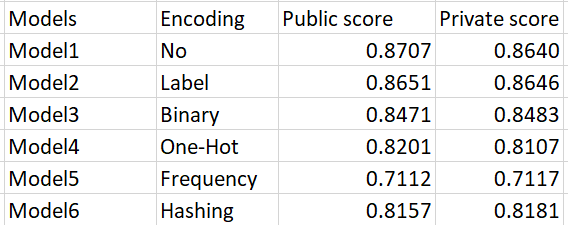

Model1 and Model2 represent the best models.

**Let's try the average of the models**

In [ ]:
# submission for model averaging
submission1_2 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2) / 2})
submission1_2.to_csv("submission1_2.csv", index = False)
submission1_2_3 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3) / 3})
submission1_2_3.to_csv("submission1_2_3.csv", index = False)
submission1_2_3_4 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3 + predictions4) / 4})
submission1_2_3_4.to_csv("submission1_2_3_4.csv", index = False)
submission1_2_3_4_5 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3 + predictions4 + predictions5) / 5})
submission1_2_3_4_5.to_csv("submission1_2_3_4_5.csv", index = False)
submission1_2_3_4_5_6 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3 + predictions4 + predictions5 + predictions6) / 6})
submission1_2_3_4_5_6.to_csv("submission1_2_3_4_5_6.csv", index = False)

# Model-averaging results

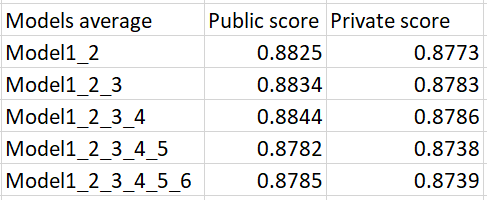

Model 1_2_3_4 gets the best score

# Step 7: Modelling (hybrid variables)

# Combination of two variables

In [ ]:
# NO encoding applied 
X_train2 = train.iloc[:,8:36]
X_test2 = test.iloc[:,8:36]

In [ ]:
# Label Encoding
X_train2_le = {}
X_test2_le = {}

for i in X_train2.columns:
    X_train2_le[i], X_test2_le[i] = lab_enc(X_train2, X_test2, i)

X_train2_le = pd.DataFrame(X_train2_le)
X_test2_le = pd.DataFrame(X_test2_le)

In [ ]:
# Binary Encoding
X_train2_bin, X_test2_bin = bin_enc(X_train2, y, X_test2)

In [ ]:
# One-Hot Encoding
X_train2_one, X_test2_one = onehot_enc(X_train2, X_test2)

In [ ]:
# Frequency Encoding
X_train2_freq = {}
X_test2_freq = {}

for i in X_train2.columns:
    X_train2_freq[i], X_test2_freq[i] = freq_enc(X_train2, X_test2, i)

X_test2_freq = pd.DataFrame(X_test2_freq)
X_train2_freq = pd.DataFrame(X_train2_freq)

In [ ]:
from category_encoders.hashing import HashingEncoder

def hash_enc(df_train, df_cv, n_components):
    hashing_enc = HashingEncoder(cols=df_train.columns, n_components=n_components).fit(X_train2, y)
        
    X_train_hashing = hashing_enc.transform(X_train2.reset_index(drop=True))
    X_val_hashing = hashing_enc.transform(X_test2.reset_index(drop=True))
    return X_train_hashing, X_val_hashing

# Hashing Encoding
X_train2_hash, X_test2_hash = hash_enc(X_train2, X_test2, 1000)

In [ ]:
# MODEL 7 (X_train2, X_test2)
# String variables are not digested by lightGBM, so we transform them back into categorical variables
X_train2 = X_train2.astype('category', copy=False)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params7 = report_perf(opt, X_train2, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 8 (X_train2_le, X_test2_le)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params8 = report_perf(opt, X_train2_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 9 (X_train2_bin, X_test2_bin)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params9 = report_perf(opt, X_train2_bin, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])


In [ ]:
# MODEL 10 (X_train2_one, X_test2_one)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params10 = report_perf(opt, X_train2_one, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 11 (X_train2_freq, X_test2_freq)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params11 = report_perf(opt, X_train2_freq, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 12 (X_train2_hash, X_test2_hash)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params12 = report_perf(opt, X_train2_hash, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])


# Step 8: Predictions

We instantiate a lightGBM using the best parameters and train our model on the entire training dataset

In [ ]:
clf7 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params7
                        )

clf8 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params8
                        )

clf9 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params9
                        )

clf10 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params10
                        )

clf11 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params11
                        )


clf12 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params12
                        )

In [ ]:
clf7.fit(X_train2, y)
clf8.fit(X_train2_le, y)
clf9.fit(X_train2_bin, y)
clf10.fit(X_train2_one, y)
clf11.fit(X_train2_freq, y)
clf12.fit(X_train2_hash, y)

In [ ]:
# We transform string variables into categories as they must be consistent 
# with the training dataset (X_train2)
X_test2 = X_test2.astype('category', copy=False)
predictions7 = clf7.predict_proba(X_test2)[:, 1].ravel()
predictions8 = clf8.predict_proba(X_test2_le)[:, 1].ravel()
predictions9 = clf9.predict_proba(X_test2_bin)[:, 1].ravel()
predictions10 = clf10.predict_proba(X_test2_one)[:, 1].ravel()
predictions11 = clf11.predict_proba(X_test2_freq)[:, 1].ravel()
predictions12 = clf12.predict_proba(X_test2_hash)[:, 1].ravel()

In [ ]:
submission7 = pd.DataFrame({'Id':ids, 'ACTION': predictions7})
submission7.to_csv("submission7.csv", index = False)
submission8 = pd.DataFrame({'Id':ids, 'ACTION': predictions8})
submission8.to_csv("submission8.csv", index = False)
submission9 = pd.DataFrame({'Id':ids, 'ACTION': predictions9})
submission9.to_csv("submission9.csv", index = False)
submission10 = pd.DataFrame({'Id':ids, 'ACTION': predictions10})
submission10.to_csv("submission10.csv", index = False)
submission11 = pd.DataFrame({'Id':ids, 'ACTION': predictions11})
submission11.to_csv("submission11.csv", index = False)
submission12 = pd.DataFrame({'Id':ids, 'ACTION': predictions12})
submission12.to_csv("submission12.csv", index = False)

# Results

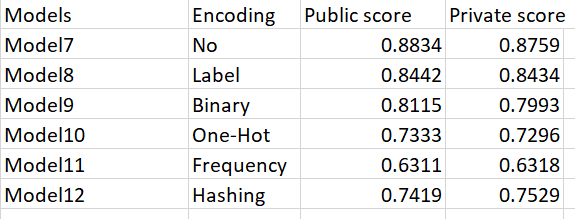

Model7 is the best model

**Let's try the average of the models**

In [ ]:
# submission for model averaging
submission7_8 = pd.DataFrame({'Id':ids, 'ACTION': (predictions7 + predictions8) / 2})
submission7_8.to_csv("submission7_8.csv", index = False)
submission7_8_9 = pd.DataFrame({'Id':ids, 'ACTION': (predictions7 + predictions8 + predictions9) / 3})
submission7_8_9.to_csv("submission7_8_9.csv", index = False)
submission7_8_9_10 = pd.DataFrame({'Id':ids, 'ACTION': (predictions7 + predictions8 + predictions9 + predictions10) / 4})
submission7_8_9_10.to_csv("submission7_8_9_10.csv", index = False)
submission7_8_9_10_11 = pd.DataFrame({'Id':ids, 'ACTION': (predictions7 + predictions8 + predictions9 + predictions10 + predictions11) / 5})
submission7_8_9_10_11.to_csv("submission7_8_9_10_11.csv", index = False)
submission7_8_9_10_11_12 = pd.DataFrame({'Id':ids, 'ACTION': (predictions7 + predictions8 + predictions9 + predictions10 + predictions11 + predictions12) / 6})
submission7_8_9_10_11_12.to_csv("submission7_8_9_10_11_12.csv", index = False)

# Model-averaging results

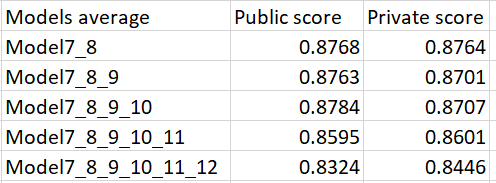

Model7_8_9_10 is the best model in the public score, but Model7_8 is the best in the private score

However, Model7 remains the best model in the public score

**Next, we combine the predictions of the best model of the original variables (Model1_2_3_4) with the best model of the hybrid variables (Model7)**


Remember: in this case the hybrid variables represent the combination of two variables

In [ ]:
# submission for model averaging
submission1_2_3_4_7 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3 + predictions4 + predictions7 ) / 5})
submission1_2_3_4_7.to_csv("submission1_2_3_4_7.csv", index = False)

**Result:** public score: 0.88668, private score: 0.88085

# Merged Datasets

In the preceding sections, we applied our lightGBM model to various datasets, each of which is the product of a distinct encoding strategy. 

But what happens if we combine the original datasets with the hybrid dataset?

In [ ]:
X_train_merged = pd.concat([X_train, X_train2], axis = 1)
X_test_merged = pd.concat([X_test, X_test2], axis = 1)

In [ ]:
# Label Encoding
X_train_me_le = {}
X_test_me_le = {}

for i in X_train_merged.columns:
    X_train_me_le[i], X_test_me_le[i] = lab_enc(X_train_merged, X_test_merged, i)

X_train_me_le = pd.DataFrame(X_train_me_le)
X_test_me_le = pd.DataFrame(X_test_me_le)

In [ ]:
# Binary Encoding
X_train_me_bin, X_test_me_bin = bin_enc(X_train_merged, y, X_test_merged)

In [ ]:
# One-Hot Encoding
X_train_me_one, X_test_me_one = onehot_enc(X_train_merged, X_test_merged)

In [ ]:
# Frequency Encoding
X_train_me_freq = {}
X_test_me_freq = {}

for i in X_train_merged.columns:
    X_train_me_freq[i], X_test_me_freq[i] = freq_enc(X_train_merged, X_test_merged, i)

X_test_me_freq = pd.DataFrame(X_test_me_freq)
X_train_me_freq = pd.DataFrame(X_train_me_freq)

In [ ]:
from category_encoders.hashing import HashingEncoder

def hash_enc(df_train, df_cv, n_components):
    hashing_enc = HashingEncoder(cols=df_train.columns, n_components=n_components).fit(X_train_merged, y)
        
    X_train_hashing = hashing_enc.transform(X_train_merged.reset_index(drop=True))
    X_val_hashing = hashing_enc.transform(X_test_merged.reset_index(drop=True))
    return X_train_hashing, X_val_hashing

# Hashing Encoding
X_train_me_hash, X_test_me_hash = hash_enc(X_train_merged, X_test_merged, 1000)

In [ ]:
# MODEL 13 (X_train_merged, X_test_merged)
# String variables are not digested by lightGBM, so we transform them back into categorical variables
X_train_merged = X_train_merged.astype('category', copy=False)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params13 = report_perf(opt, X_train_merged, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 14 (X_train_me_le, X_test_me_le)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params14 = report_perf(opt, X_train_me_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 15 (X_train_me_bin, X_test_me_bin)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params15 = report_perf(opt, X_train_me_bin, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 16 (X_train_me_one, X_test_me_one)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params16 = report_perf(opt, X_train_me_one, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 17 (X_train_me_freq, X_test_me_freq)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params17 = report_perf(opt, X_train_me_freq, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 18 (X_train_me_hash, X_test_me_hash)
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 5)     # We impose a time limit (5 minutes)

best_params18 = report_perf(opt, X_train_me_hash, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

# Step 9: Predictions

We instantiate a lightGBM using the best parameters and train our model on the entire training dataset

In [ ]:
clf13 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params13
                        )

clf14 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params14
                        )

clf15 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params15
                        )

clf16 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params16
                        )

clf17 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params17
                        )


clf18 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params18
                        )

In [ ]:
clf13.fit(X_train_merged, y)
clf14.fit(X_train_me_le, y)
clf15.fit(X_train_me_bin, y)
clf16.fit(X_train_me_one, y)
clf17.fit(X_train_me_freq, y)
clf18.fit(X_train_me_hash, y)

In [ ]:
# We transform string variables into categories as they must be consistent 
# with the training dataset (X_train2)
X_test_merged = X_test_merged.astype('category', copy=False)
predictions13 = clf13.predict_proba(X_test_merged)[:, 1].ravel()
predictions14 = clf14.predict_proba(X_test_me_le)[:, 1].ravel()
predictions15 = clf15.predict_proba(X_test_me_bin)[:, 1].ravel()
predictions16 = clf16.predict_proba(X_test_me_one)[:, 1].ravel()
predictions17 = clf17.predict_proba(X_test_me_freq)[:, 1].ravel()
predictions18 = clf18.predict_proba(X_test_me_hash)[:, 1].ravel()

In [ ]:
submission13 = pd.DataFrame({'Id':ids, 'ACTION': predictions13})
submission13.to_csv("submission13.csv", index = False)
submission14 = pd.DataFrame({'Id':ids, 'ACTION': predictions14})
submission14.to_csv("submission14.csv", index = False)
submission15 = pd.DataFrame({'Id':ids, 'ACTION': predictions15})
submission15.to_csv("submission15.csv", index = False)
submission16 = pd.DataFrame({'Id':ids, 'ACTION': predictions16})
submission16.to_csv("submission16.csv", index = False)
submission17 = pd.DataFrame({'Id':ids, 'ACTION': predictions17})
submission17.to_csv("submission17.csv", index = False)
submission18 = pd.DataFrame({'Id':ids, 'ACTION': predictions18})
submission18.to_csv("submission18.csv", index = False)

# Results

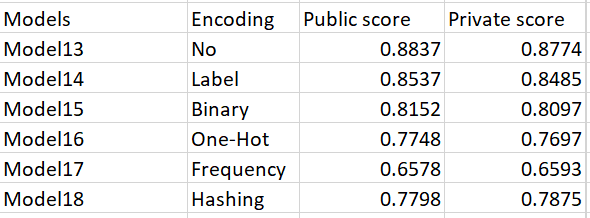

Model13 is the best model

**Let's try the average of the models**

In [ ]:
# submission for model averaging
submission13_14 = pd.DataFrame({'Id':ids, 'ACTION': (predictions13 + predictions14) / 2})
submission13_14.to_csv("submission13_14.csv", index = False)
submission13_14_15 = pd.DataFrame({'Id':ids, 'ACTION': (predictions13 + predictions14 + predictions15) / 3})
submission13_14_15.to_csv("submission13_14_15.csv", index = False)
submission13_14_15_16 = pd.DataFrame({'Id':ids, 'ACTION': (predictions13 + predictions14 + predictions15 + predictions16) / 4})
submission13_14_15_16.to_csv("submission13_14_15_16.csv", index = False)
submission13_14_15_16_17 = pd.DataFrame({'Id':ids, 'ACTION': (predictions13 + predictions14 + predictions15 + predictions16 + predictions17) / 5})
submission13_14_15_16_17.to_csv("submission13_14_15_16_17.csv", index = False)
submission13_14_15_16_17_18 = pd.DataFrame({'Id':ids, 'ACTION': (predictions13 + predictions14 + predictions15 + predictions16 + predictions17 + predictions18) / 6})
submission13_14_15_16_17_18.to_csv("submission13_14_15_16_17_18.csv", index = False)

# Model-averaging results

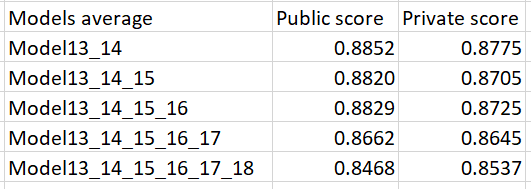

Model13_14 is the best model

**Next, we combine the predictions of the best model of the original variables (Model1_2_3_4) with the best model of the hybrid variables (Model7) and the best model of the combined dataset (Model13_14)**

In [ ]:
# submission for model averaging
submission1_2_3_4_7_13_14 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions3 + predictions4 + predictions7 + predictions13 + predictions14) / 7})
submission1_2_3_4_7_13_14.to_csv("submission1_2_3_4_7_13_14.csv", index = False)

**Result:** public score: 0.88797, private score: 0.88181

Compared to model1_2_3_4_7 the scores increased slightly, but so did the complexity, as we added the predictions of model13 and model14

# Final approach

As a last method, we select the individual (non-averaged) models that are most effective in terms of scoring: model1, model7, and model13 and resimulate by increasing the time limit to 40 minutes

In [ ]:
# MODEL 1 (X_train, X_test)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (40 minutes)

best_params1 = report_perf(opt, X_train, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 2 (X_train_le, X_test_le)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (40 minutes)

best_params2 = report_perf(opt, X_train_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 7 (X_train2, X_test2)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (40 minutes)

best_params7 = report_perf(opt, X_train2, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 8 (X_train2_le, X_test2_le)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (5 minutes)

best_params8 = report_perf(opt, X_train2_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 13 (X_train_merged, X_test_merged)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (5 minutes)

best_params13 = report_perf(opt, X_train_merged, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# MODEL 14 (X_train_me_le, X_test_me_le)

overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 40)     # We impose a time limit (5 minutes)

best_params14 = report_perf(opt, X_train_me_le, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
clf1 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params1
                        )

clf2 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params2
                        )

clf7 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params7
                        )

clf8 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params8
                        )

clf13 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params13
                        )


clf14 = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params14
                        )

In [ ]:
clf1.fit(X_train, y)
clf2.fit(X_train_le, y)
clf7.fit(X_train2, y)
clf8.fit(X_train2_le, y)
clf13.fit(X_train_merged, y)
clf14.fit(X_train_me_le, y)

In [ ]:
predictions1 = clf1.predict_proba(X_test)[:, 1].ravel()
predictions2 = clf2.predict_proba(X_test_le)[:, 1].ravel()
predictions7 = clf7.predict_proba(X_test2)[:, 1].ravel()
predictions8 = clf8.predict_proba(X_test2_le)[:, 1].ravel()
predictions13 = clf13.predict_proba(X_test_merged)[:, 1].ravel()
predictions14 = clf14.predict_proba(X_test_me_le)[:, 1].ravel()

In [ ]:
# submission for models with time limit = 40 minutes

submission1 = pd.DataFrame({'Id':ids, 'ACTION': predictions1})
submission1.to_csv("submission1.csv", index = False)
submission2 = pd.DataFrame({'Id':ids, 'ACTION':  predictions2})
submission2.to_csv("submission2.csv", index = False)
submission7 = pd.DataFrame({'Id':ids, 'ACTION': predictions7})
submission7.to_csv("submission7.csv", index = False)
submission8 = pd.DataFrame({'Id':ids, 'ACTION': predictions8})
submission8.to_csv("submission8.csv", index = False)
submission13 = pd.DataFrame({'Id':ids, 'ACTION': predictions13})
submission13.to_csv("submission13.csv", index = False)
submission14 = pd.DataFrame({'Id':ids, 'ACTION': predictions14})
submission14.to_csv("submission14.csv", index = False)

# Model averaging
submission1_2_7_8_13_14 = pd.DataFrame({'Id':ids, 'ACTION': (predictions1 + predictions2 + predictions7 + predictions8 + predictions13 + predictions14) / 6})
submission1_2_7_8_13_14.to_csv("submission1_2_7_8_13_14.csv", index = False)

# Results

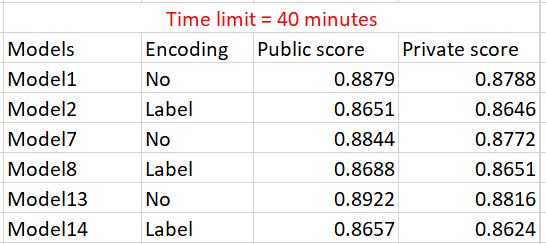

Model13 with 40 minutes of time limit is the best model for this notebook.

Now let's see the average of these models

**Model1_2_7_8_13_14:**

Public score: 0.8953, private score: 0.8888 

**(highest score for this notebook)**